In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

pd.options.display.max_rows = 999

import random
random.seed(7)

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils import check_array
from sklearn.preprocessing import LabelEncoder
from scipy import sparse
from skopt.space import Real, Categorical, Integer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler, Imputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from skopt import BayesSearchCV

In [2]:
AISLES = pd.read_csv('aisles.csv')

In [3]:
Departments = pd.read_csv('departments.csv')

In [4]:
orders = pd.read_csv('orders.csv')

In [5]:
PRODucts = pd.read_csv('products.csv')

In [6]:
order_products_train = pd.read_csv('order_products__train.csv')

In [7]:
order_products_prior = pd.read_csv('order_products__prior.csv')

In [8]:
AISLES.head()

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


In [9]:
Departments.head()

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


In [10]:
products_org = pd.merge(PRODucts, Departments, how = 'inner' , on = 'department_id', suffixes = ['p', 'd'])

In [11]:
products_org['department'].unique()

array(['snacks', 'pantry', 'beverages', 'frozen', 'personal care',
       'dairy eggs', 'household', 'babies', 'meat seafood',
       'dry goods pasta', 'pets', 'breakfast', 'canned goods', 'produce',
       'missing', 'international', 'deli', 'alcohol', 'bakery', 'other',
       'bulk'], dtype=object)

In [12]:
product_organized = pd.merge(products_org, AISLES, how = 'inner', on = 'aisle_id', suffixes = ['p', 'a'])

In [13]:
product_organized.head()

,product_id,product_name,aisle_id,department_id,department,aisle
0,1,Chocolate Sandwich Cookies,61,19,snacks,cookies cakes
1,78,Nutter Butter Cookie Bites Go-Pak,61,19,snacks,cookies cakes
2,102,Danish Butter Cookies,61,19,snacks,cookies cakes
3,172,Gluten Free All Natural Chocolate Chip Cookies,61,19,snacks,cookies cakes
4,285,Mini Nilla Wafers Munch Pack,61,19,snacks,cookies cakes


In [14]:
prior_orders = pd.merge(order_products_prior, orders, how = 'inner', on = 'order_id', suffixes = ['prior', 'o'])

In [15]:
prior_orders.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2,33120,1,1,202279,prior,3,5,9,8.0
1,2,28985,2,1,202279,prior,3,5,9,8.0
2,2,9327,3,0,202279,prior,3,5,9,8.0
3,2,45918,4,1,202279,prior,3,5,9,8.0
4,2,30035,5,0,202279,prior,3,5,9,8.0


In [16]:
train = pd.merge(order_products_train, orders, how = 'inner', on = 'order_id', suffixes = ['train', 'o'])

In [17]:
train.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,1,49302,1,1,112108,train,4,4,10,9.0
1,1,11109,2,1,112108,train,4,4,10,9.0
2,1,10246,3,0,112108,train,4,4,10,9.0
3,1,49683,4,0,112108,train,4,4,10,9.0
4,1,43633,5,1,112108,train,4,4,10,9.0


In [18]:
prior = pd.merge(prior_orders, product_organized, how = 'inner', on = 'product_id', suffixes = ['prior', 'product'])

In [19]:
post = pd.merge(train, product_organized, how = 'inner', on = 'product_id', suffixes = ['train', 'product'])

In [20]:
# concatenate prior and post for stats
frames = [prior, post]
data = pd.concat(frames)

In [21]:
data.dtypes

order_id                    int64
product_id                  int64
add_to_cart_order           int64
reordered                   int64
user_id                     int64
eval_set                   object
order_number                int64
order_dow                   int64
order_hour_of_day           int64
days_since_prior_order    float64
product_name               object
aisle_id                    int64
department_id               int64
department                 object
aisle                      object
dtype: object

In [22]:
data['reordered'].sum()/data['reordered'].count()

0.59006172428094339

In [23]:
data.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_name,aisle_id,department_id,department,aisle
0,2,33120,1,1,202279,prior,3,5,9,8.0,Organic Egg Whites,86,16,dairy eggs,eggs
1,26,33120,5,0,153404,prior,2,0,16,7.0,Organic Egg Whites,86,16,dairy eggs,eggs
2,120,33120,13,0,23750,prior,11,6,8,10.0,Organic Egg Whites,86,16,dairy eggs,eggs
3,327,33120,5,1,58707,prior,21,6,9,8.0,Organic Egg Whites,86,16,dairy eggs,eggs
4,390,33120,28,1,166654,prior,48,0,12,9.0,Organic Egg Whites,86,16,dairy eggs,eggs


### Questions:
Do customers mostly order groceries instead of, for instance, personal care? 



In [24]:
def plot_hist(d):
    plt.bar(d.keys(), d.values(), color='g')
    plt.xticks(rotation=90)

Reordering Ratio in Departments 
 department
personal care      0.321863
pantry             0.347400
international      0.369682
missing            0.394323
household          0.403339
other              0.407052
canned goods       0.458639
dry goods pasta    0.462220
frozen             0.542634
breakfast          0.561351
meat seafood       0.568625
alcohol            0.571221
snacks             0.574464
bulk               0.577090
babies             0.577680
pets               0.602557
deli               0.608130
bakery             0.628381
produce            0.650521
beverages          0.653651
dairy eggs         0.670161
Name: reordered, dtype: float64


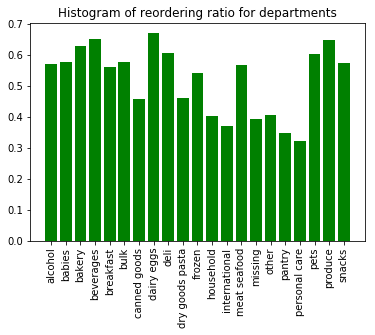

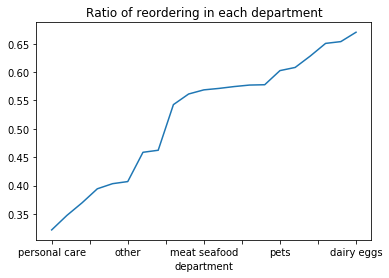

In [25]:
dep_reorders = data.groupby('department')['reordered'].sum()/data.groupby('department')['reordered'].count()
#  reordered to total ordered items ratio per department

dict_dep_reorders = dep_reorders.to_dict()
plt.figure()
plot_hist(dict_dep_reorders)
plt.title('Histogram of reordering ratio for departments')

plt.figure()
dep_reorders.sort_values().plot()
plt.title('Ratio of reordering in each department')

print('Reordering Ratio in Departments', '\n', dep_reorders.sort_values())

Reordering happens the least in the **personal care** department whereas the most **produce**, **beverages** and **dairy eggs** (*grocery*) departments. 

Total orders in Departments 
 department
bulk                 35932
other                38086
missing              77396
pets                102221
alcohol             159294
international       281155
babies              438743
personal care       468693
breakfast           739069
meat seafood        739238
household           774652
dry goods pasta     905340
deli               1095540
canned goods       1114857
bakery             1225181
pantry             1956819
frozen             2336858
beverages          2804175
snacks             3006412
dairy eggs         5631067
produce            9888378
Name: reordered, dtype: int64


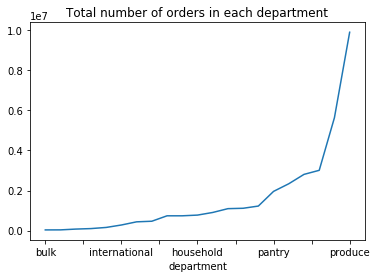

In [26]:
dep_orders = data.groupby('department')['reordered'].count() # total orders per dept

plt.figure()
dep_orders.sort_values().plot()
plt.title('Total number of orders in each department')

print('Total orders in Departments', '\n', dep_orders.sort_values())

Most of the orders are for **produce** items. The least majority of the orders are for **bulk** items.  

**Bulk** items are ordered the least in quantity but has a repetition ratio of $0.58$. Therefore, we can't conclude that bulk items are less frequently reordered. 

In [27]:
df_dep_orders = dep_orders.to_frame(name='tot_orders')
df_dep_orders = df_dep_orders.reset_index()

In [28]:
df_dep_orders

,department,tot_orders
0,alcohol,159294
1,babies,438743
2,bakery,1225181
3,beverages,2804175
4,breakfast,739069
5,bulk,35932
6,canned goods,1114857
7,dairy eggs,5631067
8,deli,1095540
9,dry goods pasta,905340


In [29]:
df_dep_orders['quan'] = 0
q1 = df_dep_orders.quantile(0.25)['tot_orders']
q2 = df_dep_orders.quantile(0.5)['tot_orders']
q3 = df_dep_orders.quantile(0.75)['tot_orders']
q4 = df_dep_orders.quantile(1)['tot_orders']
cntr = 0

for c in df_dep_orders['tot_orders']:
    if c < q1:
        df_dep_orders.quan[cntr] = 1
    elif q1 <= c < q2:
        df_dep_orders.quan[cntr] = 2
    elif df_dep_orders.quantile(0.5)['tot_orders'] <= c < df_dep_orders.quantile(0.75)['tot_orders']:
        df_dep_orders.quan[cntr]= 3
    else:
        df_dep_orders.quan[cntr] = 4
    cntr += 1

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWa

In [30]:
df_dep_orders.groupby('quan')['tot_orders'].sum()

quan
1      412929
2     2666898
3     5115570
4    25623709
Name: tot_orders, dtype: int64

In [31]:
df_dep_orders.sort_values(by = ['quan', 'tot_orders'])

,department,tot_orders,quan
5,bulk,35932,1
15,other,38086,1
14,missing,77396,1
18,pets,102221,1
0,alcohol,159294,1
12,international,281155,2
1,babies,438743,2
17,personal care,468693,2
4,breakfast,739069,2
13,meat seafood,739238,2


In [32]:
d = data.groupby(['user_id','product_id'])['reordered'].sum()
df = d.to_frame()
df = df.reset_index()

In [ ]:
no_reorder = df[df['reordered'] == 0]

In [ ]:
no_reordered_products = pd.merge(no_reorder, product_organized, how = 'inner', on = 'product_id', suffixes = ['no', 'pro'])

In [ ]:
no_orders = no_reordered_products.groupby('department')['user_id'].count()

plt.figure()
no_orders.sort_values().plot()
plt.title('One time orders in each department')

print('One time orders in Departments', '\n', no_orders.sort_values())

Though *pantry* made it to fourth quantile ($>75\%$) from the bottom of that quantile, it is clearly seen that groceries are certainly a big part of the orders. However, we have also observed the repetition ratio of pantry items as $0.34$, whereas it was $0.65$ for produce items. 